[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\digit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\digit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\digit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\digit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7910 - loss: 1.6058 - val_accuracy: 0.8128 - val_loss: 1.3940 - learning_rate: 1.0000e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8233 - loss: 1.3585 - val_accuracy: 0.8128 - val_loss: 1.2885 - learning_rate: 1.0000e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8275 - loss: 1.2468 - val_accuracy: 0.8128 - val_loss: 1.1954 - learning_rate: 1.0000e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8250 - loss: 1.1614 - val_accuracy: 0.8128 - val_loss: 1.1113 - learning_rate: 1.0000e-04
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8279 - loss: 1.0690 - val_accuracy: 0.8128 - val_loss: 1.0385 - learning_rate: 1.0000e-04
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8281 - loss: 0.9488 - val_accuracy: 0.7989 - val_loss: 0.9849 - learning_rate: 1.0000e-04
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8991 - loss:

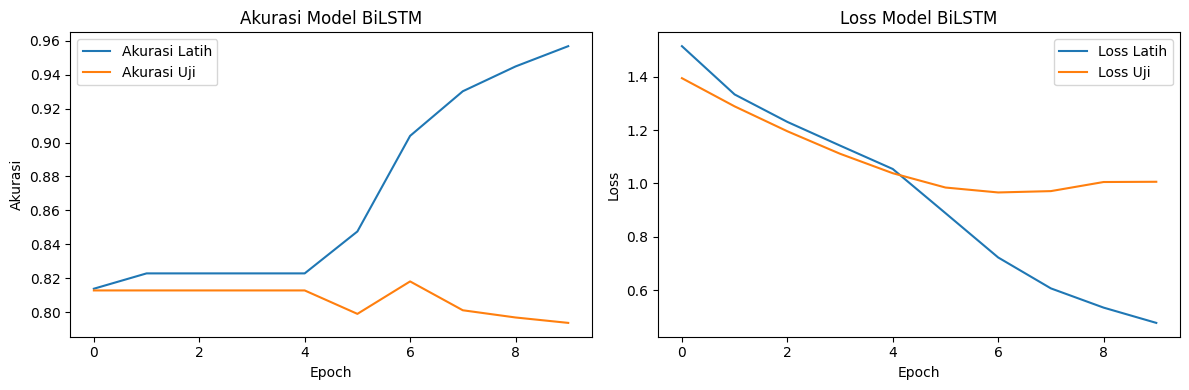

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.32      0.40       176
           1       0.86      0.93      0.89       764

    accuracy                           0.82       940
   macro avg       0.69      0.63      0.65       940
weighted avg       0.79      0.82      0.80       940



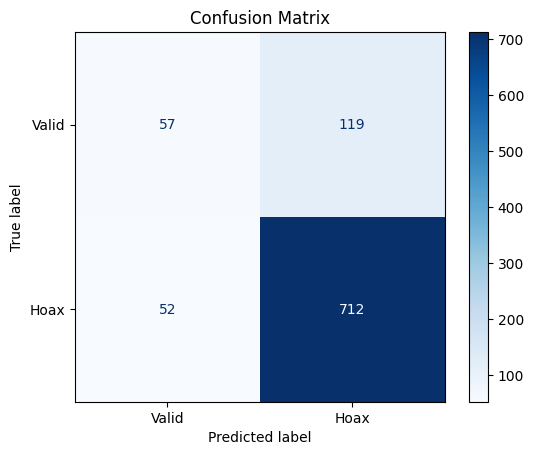

Model telah disimpan sebagai 'bilstm_hoax_detection.h5'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Teks: Berita ini benar-benar palsu, jangan percaya!
Prediksi: Valid (Probabilitas: 0.47)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Teks: Pemerintah baru saja mengumumkan kebijakan baru untuk pendidikan.
Prediksi: Hoax (Probabilitas: 0.94)


In [5]:
# Import pustaka yang dibutuhkan
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Download stopwords dan pustaka lainnya jika belum diunduh
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Load Dataset
dataset_path = 'cleaned_dataset.csv'  # Ganti dengan path ke dataset
dataset = pd.read_csv(dataset_path)

# 2. Preprocessing Teks
stop_words = set(stopwords.words('indonesian'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)  # Hapus tanda baca dan angka
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    else:
        return ''  # Jika input bukan string, kembalikan string kosong

dataset['content'] = dataset['content'].fillna('')  # Ganti NaN dengan string kosong
dataset['processed_content'] = dataset['content'].apply(preprocess_text)

# 3. Tokenisasi dan Padding
tokenizer = Tokenizer(num_words=5000)  # Batasi hingga 5000 kata
tokenizer.fit_on_texts(dataset['processed_content'])
X = tokenizer.texts_to_sequences(dataset['processed_content'])
X_pad = pad_sequences(X, padding='post', maxlen=200)

# Target label
y = dataset['label']

# 4. Membagi Data Latih dan Uji
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# 5. Membangun Model BiLSTM dengan Regularisasi
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))  # Embedding layer
model.add(Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)))  # BiLSTM pertama
model.add(Bidirectional(LSTM(128, dropout=0.3)))  # BiLSTM kedua
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Dense layer dengan regularisasi L2
model.add(Dropout(0.3))  # Dropout tambahan
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Kompilasi Model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 6. Callbacks: Early Stopping dan Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

# 7. Melatih Model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]
)

# 8. Evaluasi Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi Model BiLSTM: {accuracy * 100:.2f}%")

# 9. Menampilkan Grafik Akurasi dan Loss
plt.figure(figsize=(12, 4))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Latih')
plt.plot(history.history['val_accuracy'], label='Akurasi Uji')
plt.title('Akurasi Model BiLSTM')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Latih')
plt.plot(history.history['val_loss'], label='Loss Uji')
plt.title('Loss Model BiLSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 10. Classification Report
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Valid", "Hoax"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 11. Menyimpan Model
model.save('/content/hasil_model/bilstm_hoax_detection.h5')
print("Model telah disimpan sebagai 'bilstm_hoax_detection.h5'")

# 12. Prediksi Baru
def predict_text(text):
    # Preprocessing teks baru
    processed_text = preprocess_text(text)
    tokenized_text = tokenizer.texts_to_sequences([processed_text])
    padded_text = pad_sequences(tokenized_text, padding='post', maxlen=200)

    # Prediksi
    prediction = model.predict(padded_text)
    result = "Hoax" if prediction[0][0] > 0.5 else "Valid"
    print(f"Teks: {text}")
    print(f"Prediksi: {result} (Probabilitas: {prediction[0][0]:.2f})")

# Contoh Prediksi
predict_text("Berita ini benar-benar palsu, jangan percaya!")
predict_text("Pemerintah baru saja mengumumkan kebijakan baru untuk pendidikan.")